This notebook is to calibrate the priors to the training set galaxies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import multiprocessing as mp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.special import gamma

from modules.galaxyphoto import get_bandpass_dict, Sed
from modules.photomatching import match_galaxy

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the bandpass dictionary

In [3]:
bandpass_dict = get_bandpass_dict()

Load the training galaxies

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Load the trained templates

In [5]:
N = 8
trained_templates = dict()
for i in range(N):
    template = "N"+str(N)+"-"+str(i+1)
    x,y = np.loadtxt('templates/'+template+'.sed',unpack=True)
    trained_templates[template] = Sed(x,y)

Match the galaxies to the templates

In [6]:
%%time
Ncpus = None

# open the cpu pool
Ncpus = mp.cpu_count() if Ncpus is None else Ncpus
pool = mp.Pool(Ncpus)

# match the galaxies
matched_galaxies = pool.starmap(match_galaxy,
                                [(galaxy,trained_templates,bandpass_dict) 
                                    for galaxy in galaxies])

# close the cpu pool
pool.close()

CPU times: user 13.9 s, sys: 1.11 s, total: 15 s
Wall time: 1min 59s


Get the magnitudes and galaxy types

In [7]:
mMin = 17.5
mMax = 25.8

In [8]:
m0s = []
zs = []
Ts = []

for galaxy in matched_galaxies:
    
    m0 = galaxy.m0
    if m0 < mMin or m0 > mMax:
        continue
    m0s.append(galaxy.m0)
    
    zs.append(galaxy.redshift)
    
    template_int = int(galaxy.template.split('-')[1])
    if template_int <= 1:
        Ts.append('El')
    elif template_int <= 5:
        Ts.append('Sp')
    else:
        Ts.append('Im')
        
m0s = np.array(m0s)
zs = np.array(zs)
Ts = np.array(Ts)

Plot the galaxy type fractions as a function of magnitude

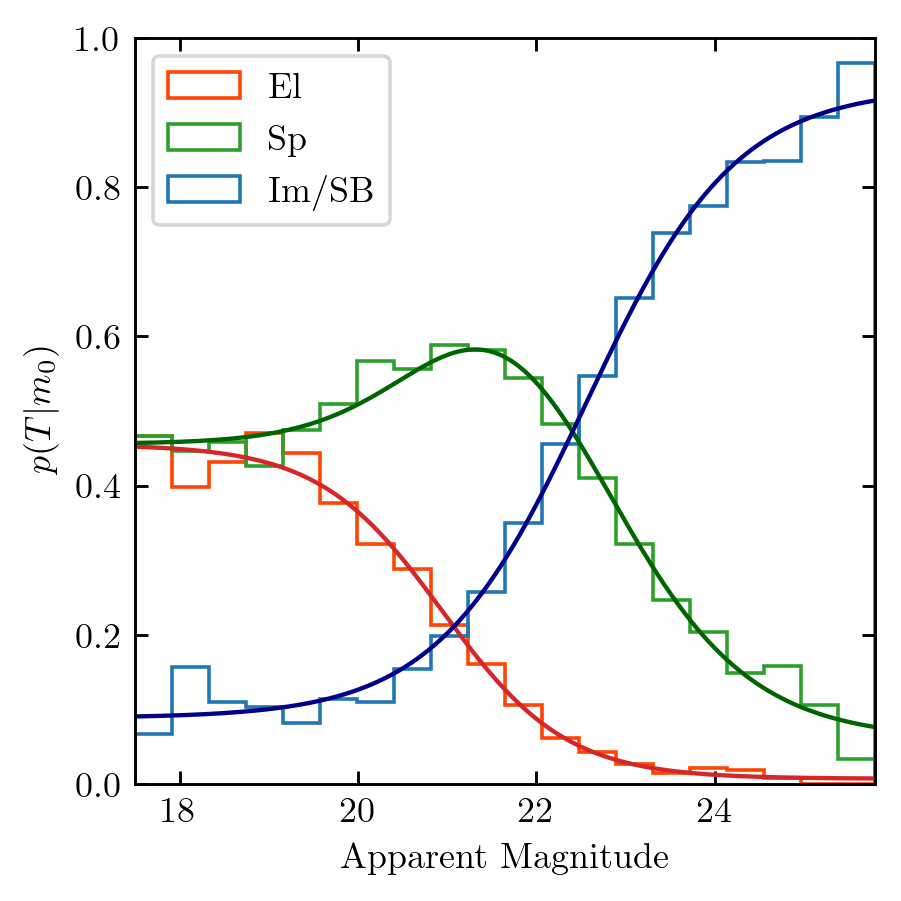

In [9]:
fig,ax = plt.subplots(constrained_layout=True)

mBins = 20

# histogram of all galaxies
w_all,x_all = np.histogram(m0s,bins=mBins,range=(mMin,mMax))
x_all = np.array([0.5*(x_all[i]+x_all[i+1]) for i in range(len(x_all)-1)])

# histogram of El types
idx = np.where(Ts == 'El')
m0_El = m0s[idx]
w_El,x_El = np.histogram(m0_El,bins=mBins,range=(mMin,mMax))
x_El = np.array([0.5*(x_El[i]+x_El[i+1]) for i in range(len(x_El)-1)])

# histogram of Sp types
idx = np.where(Ts == 'Sp')
m0_Sp = m0s[idx]
w_Sp,x_Sp = np.histogram(m0_Sp,bins=mBins,range=(mMin,mMax))
x_Sp = np.array([0.5*(x_Sp[i]+x_Sp[i+1]) for i in range(len(x_Sp)-1)])

# histogram of Im types
idx = np.where(Ts == 'Im')
m0_Im = m0s[idx]
w_Im,x_Im = np.histogram(m0_Im,bins=mBins,range=(mMin,mMax))
x_Im = np.array([0.5*(x_Im[i]+x_Im[i+1]) for i in range(len(x_Im)-1)])

# plot the histograms of fractions
ax.hist(x_El, weights=w_El/w_all, bins=mBins, range=(mMin,mMax), histtype='step', label='El', color='orangered')
ax.hist(x_Sp, weights=w_Sp/w_all, bins=mBins, range=(mMin,mMax), histtype='step', label='Sp', color='C2')
ax.hist(x_Im, weights=w_Im/w_all, bins=mBins, range=(mMin,mMax), histtype='step', label='Im/SB', color='C0')
ax.legend(loc='upper left')


# define the logistic function for the El and Im priors
f = lambda x,L,k,m,c: L/(1+np.exp(-k*(x-m))) + c

# fit the El prior
popt,pcov = curve_fit(f, x_El, w_El/w_all, p0=(0.45,-1,21,0))
El_params = popt.copy()
El_errs = np.sqrt(np.diag(pcov))
pe = lambda x: f(x,*El_params)

# fit the Im prior
popt,pcov = curve_fit(f, x_Im, w_Im/w_all, p0=(0.1,1,22,0.1))
Im_params = popt.copy()
Im_errs = np.sqrt(np.diag(pcov))
pi = lambda x: f(x,*Im_params)

# calculate the Sp prior from the El, Im priors
ps = lambda x: 1 - (pe(x) + pi(x))

# plot all the priors
x = np.linspace(mMin,mMax,1000)
ax.plot(x,pe(x),c='C3')
ax.plot(x,ps(x),c='darkgreen')
ax.plot(x,pi(x),c='darkblue')


ax.set_xlim(mMin,mMax)
ax.set_ylim(0,1)
ax.set_xlabel("Apparent Magnitude")
ax.set_ylabel("$p(T|m_0)$")
plt.show()

#fig.savefig('plots/class_vs_mag.pdf')

Print the parameters for $p(T|m_0) = \frac{L_T}{1+e^{-\kappa_L(m_0-m_T)}} + C_T$

In [10]:
param_names = ['L_El','k_El','m_El','C_El','L_Im','k_Im','m_Im','C_Im']
params = np.array([El_params,Im_params]).flatten()
errs = np.array([El_errs,Im_errs]).flatten()
for name,val,err in zip(param_names,params,errs):
    print("{:<6}{:>8.3f}{:>8.3f}".format(name,val,err))

L_El     0.448   0.017
k_El    -1.448   0.160
m_El    20.949   0.084
C_El     0.007   0.009
L_Im     0.845   0.031
k_Im     1.195   0.107
m_Im    22.560   0.081
C_Im     0.089   0.013


Now make the prior $p(z|T,m_0)$. First, I fit lines to z vs m to get approximate initial parameters for $Z_T$.

In [11]:
# define the function for Z_T
zmt = lambda m0,z0,kmt: z0 + kmt*(m0 - 20)


# set initial parameters for El
x = []
y = []
for m,z,t in zip(m0s,zs,Ts):
    if t == 'El':
        x.append(m)
        y.append(z)
popt,pcov = curve_fit(zmt,x,y)

init_ae  = 3.7
init_z0e = popt[0]
init_kme = popt[1]


# set initial paramters for Sp
x = []
y = []
for m,z,t in zip(m0s,zs,Ts):
    if t == 'Sp':
        x.append(m)
        y.append(z)
popt,pcov = curve_fit(zmt,x,y)

init_as  = 3.3
init_z0s = popt[0]
init_kms = popt[1]


# set initial parameters for Im
x = []
y = []
for m,z,t in zip(m0s,zs,Ts):
    if t == 'Im':
        x.append(m)
        y.append(z)
popt,pcov = curve_fit(zmt,x,y)

init_ai  = 2.3
init_z0i = popt[0]
init_kmi = popt[1]


# save all the initial parameters in an array
init_params = [init_ae, init_z0e, init_kme,
               init_as, init_z0s, init_kms,
               init_ai, init_z0i, init_kmi]

This is the negative log-likelihood I will be minimizing (thereby maximizing the likelihood)

In [12]:
def negLnLikelihood(params):
    
    ae  = params[0]
    z0e = params[1]
    kme = params[2]
    As  = params[3]
    z0s = params[4]
    kms = params[5]
    ai  = params[6]
    z0i = params[7]
    kmi = params[8]
    
    # initialize the arrays for all the parameters
    alphas = np.zeros(len(Ts_))
    z0ts = np.zeros(len(Ts_))
    kmts = np.zeros(len(Ts_))
    pT = m0s.copy()
    
    # set the values of the parameter arrays according
    # to galaxy types
    idx = np.where( Ts_ == 'El' )
    alphas[idx] = ae
    z0ts[idx] = z0e
    kmts[idx] = kme
    pT[idx] = pe(m0s_[idx])
    idx = np.where( Ts_ == 'Sp' )
    alphas[idx] = As
    z0ts[idx] = z0s
    kmts[idx] = kms
    pT[idx] = ps(m0s_[idx])
    idx = np.where( Ts_ == 'Im' )
    alphas[idx] = ai
    z0ts[idx] = z0i
    kmts[idx] = kmi
    pT[idx] = pi(m0s_[idx])
    
    # calculate the array of Z_T's
    zmts = zmt(m0s_,z0ts,kmts)
    
    # use only positive Z_T's
    idx = np.where(zmts > 0)
    m0s__ = m0s_[idx]
    zs__ = zs_[idx]
    alphas = alphas[idx]
    zmts = zmts[idx]
    kmts = kmts[idx]
    pT = pT[idx]
    
    # calculate the normalization constant
    norm = 1/alphas * gamma((alphas+1)/alphas) * zmts**(alphas+1)
    # calculate p(z|T,m_0)
    pz = 1/norm * zs__**alphas * np.exp(-(zs__/zmts)**alphas)
    
    # calculate p(z,t|m_0) = p(T|m_0) * p(z|T,m_0)
    prob = pT*pz
    # fix any underflows (i.e. change zeros to a small positive number)
    prob_min = prob[prob > 0].min()
    prob = np.clip(prob, prob_min/100, None)
    
    # calculate the log-likelihood
    lnL = np.log(prob).sum()
    
    # return negative log-likelihood
    return -1*lnL
    
    

Now I bootstrap the minimization to approximate the parameters and their uncertainties.

In [50]:
%%time

idx_ordered = np.arange(len(zs))
np.random.seed(11)

params = []

for i in range(100):
    
    # random sample with replacement
    idx = np.random.choice(idx_ordered, size=len(zs), replace=True)
    Ts_ = Ts[idx].copy()
    zs_ = zs[idx].copy()
    m0s_ = m0s[idx].copy()
    
    # calculate parameters for this sample
    results = minimize(negLnLikelihood, init_params)
    # save parameters to list
    params.append(results.x)

# calculate the mean and uncertainty of all the parameters
params = np.array(params).T
means = np.array([np.mean(param) for param in params])
errs = np.array([np.std(param) for param in params])

/home/jfcrenshaw/miniconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


CPU times: user 16min 58s, sys: 40 ms, total: 16min 58s
Wall time: 16min 58s


Print the results

In [59]:
param_names = ['alpha_El','z0_El','km_El','alpha_Sp','z0_Sp','km_Sp','alpha_Im','z0_Im','km_Im']
for name,mean,err in zip(param_names,means,errs):
    print("{:<10}{:>8.3f}{:>8.3f}".format(name,mean,err))

alpha_El     3.878   0.042
z0_El        0.484   0.003
km_El        0.119   0.002
alpha_Sp     3.396   0.037
z0_Sp        0.493   0.003
km_Sp        0.124   0.002
alpha_Im     2.215   0.033
z0_Im        0.361   0.009
km_Im        0.130   0.008
